<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:15px 15px;">Model Training for Auto 2W Loan Approval</p>

#### 1.1 Import Data and Required Packages
##### Importing Basic, Preprocessing and Model Training Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


#Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/credit_data.csv')

In [3]:
#dropping duplicate records
df = df.drop_duplicates()

In [4]:
# Treating missing values
df['Occupation'] = df['Occupation'].fillna('Others')

In [5]:
#Feature Engineering and Removing Very low cost vehicle data
df['TwoWheeler Cost'] = round((df['Loan Amount']/df['LTV Ratio'])*100,0)

df = df[df['TwoWheeler Cost']>=20000.0]

In [6]:
# Calculate the number of rows to select (10% of the total number of rows)
sample_size = int(0.10 * len(df))

# Randomly select 10% of the rows
random_indices = np.random.choice(df.index, sample_size, replace=False)
selected_rows = df.loc[random_indices]

# List of columns to assign "Others" to
columns_to_assign_others = ['State','City'] 

# Assign "Others" to the selected rows in the specified columns
selected_rows[columns_to_assign_others] = 'Other'

# Update the original DataFrame with the modified selected rows
df.loc[random_indices] = selected_rows

#### Preparing X and Y variables

In [7]:
X = df.drop(columns=['Profile Score','TwoWheeler Cost'],axis=1)
y = df['Profile Score']

In [8]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=True))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
        transformers=[
        ("cat", categorical_transformer, cat_features),
         ("num", numerical_transformer, num_features),
        ]        
        ,remainder="passthrough"
)

# Create a pipeline that includes the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [9]:
X_transform = pipeline.fit_transform(X)

In [10]:
# Get the transformed column names
transformed_column_names = []

if len(cat_features) > 0:
    onehot_encoder = pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot']
    feature_names = onehot_encoder.get_feature_names_out(input_features=cat_features)
    transformed_column_names.extend(feature_names)

# Append numerical column names
transformed_column_names.extend(num_features)


In [11]:
#creating three sets - training, test and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_transform, y, test_size=0.2, random_state=42)

# Splitting temporary set into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

#### Create an Evaluate Function to give all metrics after model Training

In [12]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [13]:
#Trying out different models for the best performance
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "XGBRegressor": XGBRegressor(verbosity=0),
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "Decision Tree": DecisionTreeRegressor(),
    # "Random Forest Regressor": RandomForestRegressor(),
}

In [14]:
# Defining Hyper Parameters for fine tuning and selecting the best model
params = {
    "Linear Regression": {
        'fit_intercept': [True, False]
    },
    "Lasso": {
        'alpha': [0.1, 0.01, 0.001]
    },
    "Ridge": {
        'alpha': [0.1, 0.01, 0.001]
    },
    "Decision Tree": {
        'criterion': ['absolute_error','squared_error', 'friedman_mse', 'poisson'],
        'splitter': ['best', 'random'],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
    },
    "Random Forest Regressor": {
        'n_estimators': [16,64, 128],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4],
    },
    "XGBRegressor": {
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [8, 16, 32, 64,128],
        'max_depth': [3, 4, 6,8],
        'subsample': [0.6, 0.7, 0.8, 0.9],
    },
    "CatBoost Regressor": {
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    }
}

### Running Hyper Parameter tuning for different models

In [45]:
#Defining model_list and r2_list to get the performance benchmark for all models

data_list = []

#Hyper parameter tuning for each model in the original list across different params
for i in range(len(list(models))):
    model = list(models.values())[i]
    para=params[list(models.keys())[i]]
    
    gs = RandomizedSearchCV(model, param_distributions=para, cv=3, n_iter=50,n_jobs=-1)
  
    gs.fit(X_train,y_train)

    model.set_params(**gs.best_params_)
    model.fit(X_train,y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_val, y_val_pred)

    test_model_score = r2_score(y_val,y_val_pred)
        
    print(list(models.keys())[i])
    
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_
    best_score = gs.best_score_
    
    # Print the best parameters and best score
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
      
    data_list.append({'Model': list(models.keys())[i], 'BestScore': model_test_r2, 'ModelParams': best_params})

    
    print('='*35)
    print('\n')

/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear Regression
Best Parameters: {'fit_intercept': False}
Best Score: 0.7285659017218412
Model performance for Training set
- Root Mean Squared Error: 12.7508
- Mean Absolute Error: 10.4691
- R2 Score: 0.7289
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7309
- Mean Absolute Error: 10.4699
- R2 Score: 0.7284




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso
Best Parameters: {'alpha': 0.01}
Best Score: 0.728597911021664
Model performance for Training set
- Root Mean Squared Error: 12.7545
- Mean Absolute Error: 10.4745
- R2 Score: 0.7287
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7343
- Mean Absolute Error: 10.4755
- R2 Score: 0.7282




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge
Best Parameters: {'alpha': 0.1}
Best Score: 0.7285707344876329
Model performance for Training set
- Root Mean Squared Error: 12.7508
- Mean Absolute Error: 10.4691
- R2 Score: 0.7289
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7310
- Mean Absolute Error: 10.4700
- R2 Score: 0.7284




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

XGBRegressor
Best Parameters: {'subsample': 0.6, 'n_estimators': 128, 'max_depth': 8, 'learning_rate': 0.1}
Best Score: 0.8808536720444954
Model performance for Training set
- Root Mean Squared Error: 7.2302
- Mean Absolute Error: 5.7121
- R2 Score: 0.9128
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.3233
- Mean Absolute Error: 6.5029
- R2 Score: 0.8839


CatBoost Regressor
Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8}
Best Score: 0.8739697877366893
Model performance for Training set
- Root Mean Squared Error: 8.4645
- Mean Absolute Error: 6.6547
- R2 Score: 0.8805
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.6522
- Mean Absolute Error: 6.7869
- R2 Score: 0.8745


Decision Tree
Best Parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}
Best Score: 0.8162521620994999

### Results - XGboost gives good results on training as well as test data

In [14]:
data = pd.DataFrame(data_list)

# Sort the DataFrame by the 'Best Scire' in descending order
data = data.sort_values(by='BestScore', ascending=False)

# Reset the index to have continuous index values
data.reset_index(drop=True, inplace=True)

# Print the resulting sorted DataFrame
print(data)

NameError: name 'data_list' is not defined

### Final Model - XG boost 

In [15]:
#Finalizing XG boost which is best combination of training and cross validation performance
model = XGBRegressor()
xgb = XGBRegressor(subsample=0.6, n_estimators=128, max_depth=8, learning_rate=0.1)

xgb_trained = xgb.fit(X_train, y_train)

y_test_pred = xgb_trained.predict(X_test)

y_val_pred =  xgb_trained.predict(X_val)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

model_val_mae , model_val_rmse, model_val_r2 = evaluate_model(y_val, y_val_pred)

print(" RMSE of the model on test set is %.2f" %model_test_rmse)

print(" R2 of the model on test set is %.2f" %model_test_r2)

print(" RMSE of the model on validation set is %.2f" %model_val_rmse)

print(" R2 of the model on validation set is %.2f" %model_val_r2)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


 RMSE of the model on test set is 8.31
 R2 of the model on test set is 0.88
 RMSE of the model on validation set is 8.32
 R2 of the model on validation set is 0.88


## Getting feature importance

In [16]:
feature_importance = xgb.get_booster().get_score(importance_type='weight')

# Create a dictionary of feature names and feature importance scores
feature_importance_mapping = {}
for i, col_name in enumerate(transformed_column_names):
    feature_importance_mapping[col_name] = feature_importance.get(f'f{i}', 0)  # Assuming feature names are 'f0', 'f1', ...

# Sort the feature importance dictionary by score in descending order
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame from the sorted feature importances
df_feature_imp = pd.DataFrame(sorted_feature_importance, columns=["Feature", "Importance"])

In [17]:
pd.set_option('display.max_rows', None)

df_feature_imp

,Feature,Importance
0,Credit Score,3449.0
1,LTV Ratio,3097.0
2,Credit History Length,2651.0
3,Loan Tenure,2594.0
4,Income,2506.0
5,Age,2241.0
6,Loan Amount,2033.0
7,Employment Profile_Salaried,466.0
8,Employment Profile_Student,421.0
9,Employment Profile_Unemployed,398.0


<Axes: ylabel='Feature'>

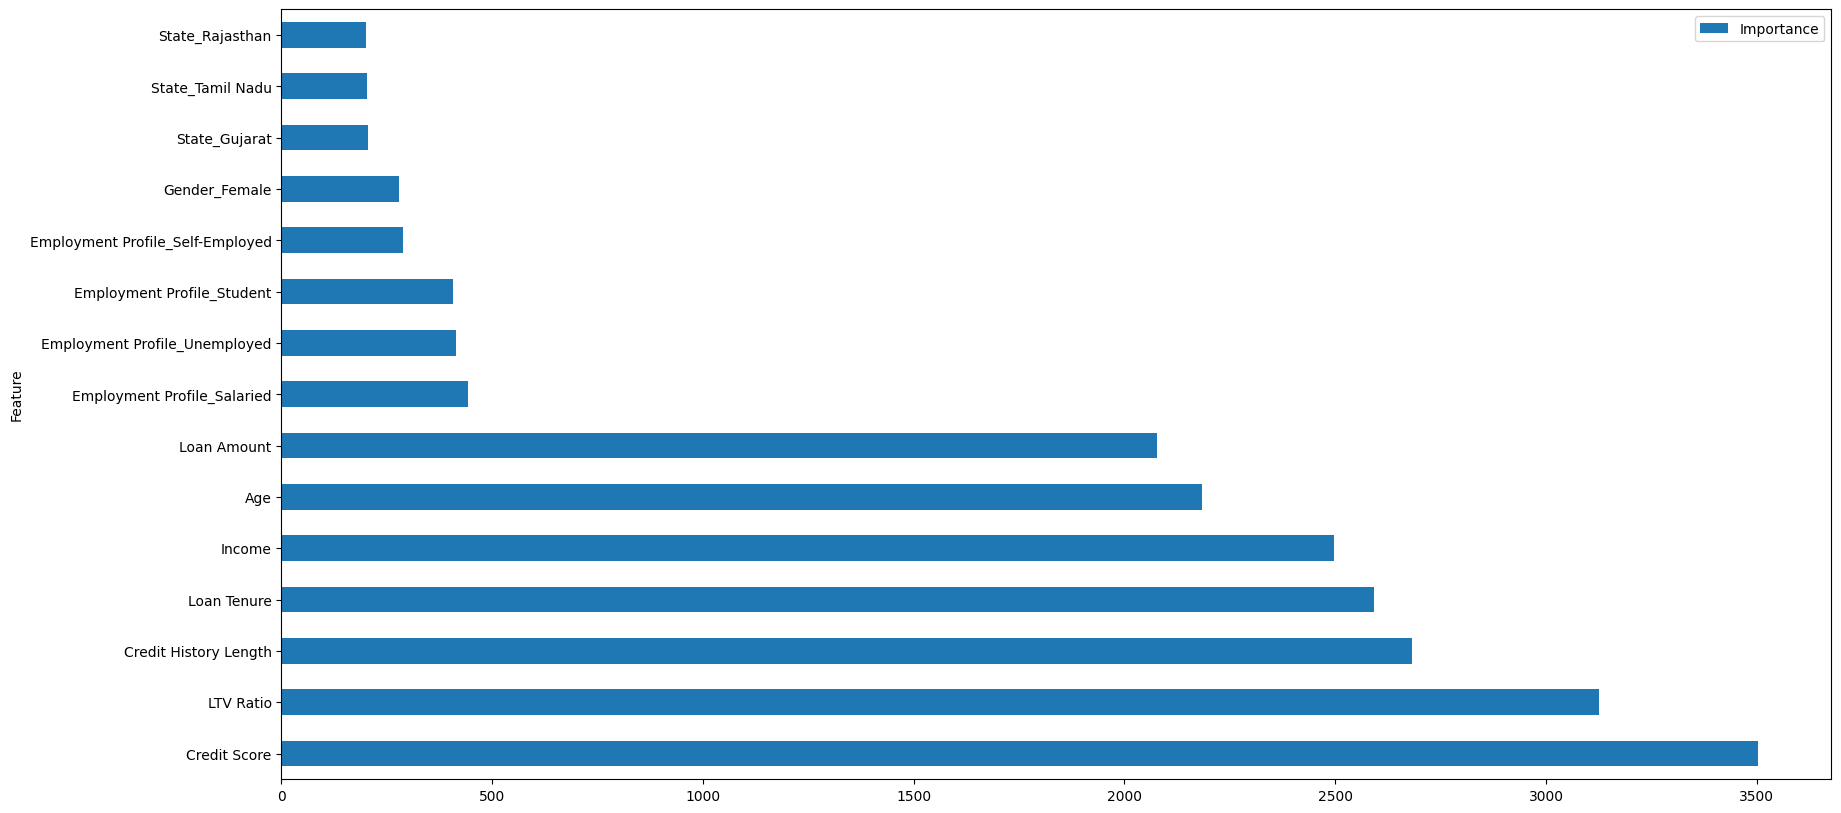

In [17]:
df_feature_imp.nlargest(15, columns="Importance").reset_index(drop=True).plot(kind='barh', y='Importance', x='Feature', figsize=(20, 10))

### Shap values for explaining model

In [18]:
# Create an explainer for the XGBoost model
explainer = shap.Explainer(xgb, X_train.toarray())  # X_train is your training data

[14:53:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


### Checking the shap values for low profile score 

In [36]:
df.head()
df_low_score = df[df['Profile Score'] < 50.0]

df_low_score = df_low_score.head(1000)

X_sample = df_low_score.drop(columns=['Profile Score','TwoWheeler Cost'],axis=1)
y_sample = df_low_score['Profile Score']

X_sample_transform = pipeline.transform(X_sample)

# Compute SHAP values for the provided data
shap_values = explainer.shap_values(X_sample_transform.toarray())

In [37]:
df_low_score.head(10)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,TwoWheeler Cost
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer,164591.0
6,29,Male,15000,378,89,1,26819,108,No,Uttar Pradesh,Lucknow,95.000000,Self-Employed,25,Farmer,28231.0
10,69,Male,166000,384,381,1,103472,14,No,Tamil Nadu,Coimbatore,95.000000,Self-Employed,13,Shopkeeper,108918.0
13,19,Female,25000,350,227,0,30156,30,No,Tamil Nadu,Chennai,64.834587,Student,49,Student,46512.0
18,34,Female,44000,300,441,0,95976,55,No,West Bengal,Kolkata,91.204851,Salaried,15,Software Engineer,105231.0
25,61,Female,41000,307,104,0,23296,99,No,Rajasthan,Udaipur,58.686622,Unemployed,23,Others,39696.0
32,23,Female,32000,442,314,2,67958,83,No,Telangana,Hyderabad,77.542092,Freelancer,43,Independent Consultant,87640.0
37,63,Female,72000,344,168,0,103424,30,No,Maharashtra,Mumbai,87.877503,Salaried,46,Civil Servant,117691.0
42,26,Female,48000,300,349,0,127696,30,No,Uttar Pradesh,Lucknow,70.527548,Unemployed,19,Others,181058.0
43,34,Female,77000,326,160,0,93422,13,No,Tamil Nadu,Chennai,95.000000,Salaried,19,Doctor,98339.0


In [40]:
# You can visualize SHAP values for a specific prediction (e.g., the first instance in your sample)
shap.initjs()  

# Assuming you want to explain the first record (you can change the index as needed)
record_index = 8

# Extract the SHAP values for the chosen record
shap_values_for_record = shap_values[record_index]

# Convert the SHAP values and data for the record to a format that shap.force_plot expects
shap_values_for_plot = np.array(shap_values_for_record)  # Convert to NumPy array
record_data_for_plot = X_sample_transform.toarray()[record_index]  # Convert to a NumPy array

shap.force_plot(explainer.expected_value, shap_values_for_record, X_sample_transform.toarray()[record_index], feature_names=transformed_column_names)

In [67]:
X_sample.head()

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Occupation
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,Software Engineer
6,29,Male,15000,378,89,1,26819,108,No,Uttar Pradesh,Lucknow,95.000000,Self-Employed,Farmer
10,69,Male,166000,384,381,1,103472,14,No,Tamil Nadu,Coimbatore,95.000000,Self-Employed,Shopkeeper
13,19,Female,25000,350,227,0,30156,30,No,Tamil Nadu,Chennai,64.834587,Student,Student
18,34,Female,44000,300,441,0,95976,55,No,West Bengal,Kolkata,91.204851,Salaried,Software Engineer


### Plot y_pred and y_test

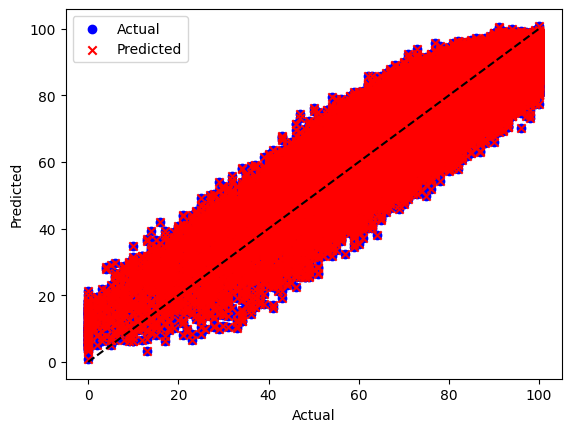

In [19]:
# Scatter plot with different markers or colors for actual and predicted
plt.scatter(y_test, y_test_pred, label='Actual', marker='o', c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

plt.xlabel('Actual')
plt.ylabel('Predicted')

# You can also add a legend to distinguish between actual and predicted
plt.scatter(y_test, y_test_pred, label='Predicted', marker='x', c='red')
plt.legend()

plt.show()

### Plotting histogram of residuals

/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


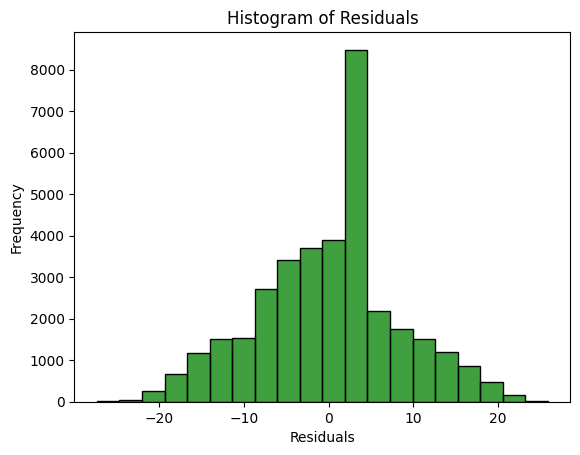

In [20]:
y_test_pred = y_test_pred.flatten()
residuals = y_test - y_test_pred

sns.histplot(residuals, bins=20,color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

#### Difference between Actual and Predicted Values

In [21]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
12365,96,97.103027,-1.103027
79571,77,65.839699,11.160301
67139,96,97.959229,-1.959229
236574,97,95.118111,1.881889
5911,70,80.212181,-10.212181
...,...,...,...
87653,100,94.399826,5.600174
81532,66,46.330193,19.669807
35233,100,95.622765,4.377235
155832,85,93.146614,-8.146614


## Model Training using Tensorflow (Neural Net)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
# Convert the CSR matrix to a dense Numpy array
X_dense = X_train.toarray()

# Convert the Pandas Series to a Numpy array
Y_array = y_train.values

# Create a Keras Sequential model
model = Sequential()


# Add your layers here
model.add(Dense(128, activation='relu', input_shape=(X_dense.shape[1],), kernel_initializer=initializers.he_normal()))  # Add a hidden layer with 128 units and ReLU activation
model.add(Dense(64, activation='relu',kernel_initializer=initializers.he_normal()))  # Add another hidden layer with 64 units and ReLU activation
model.add(Dense(1, activation='linear',kernel_initializer=initializers.he_normal()))  # Output layer (linear activation)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_dense, Y_array, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
2670/2670 [==============================] - 2s 545us/step - loss: 245.6359 - val_loss: 80.6134
Epoch 2/30
2670/2670 [==============================] - 1s 543us/step - loss: 80.0539 - val_loss: 78.7034
Epoch 3/30
2670/2670 [==============================] - 1s 529us/step - loss: 79.4904 - val_loss: 81.4645
Epoch 4/30
2670/2670 [==============================] - 1s 520us/step - loss: 79.0992 - val_loss: 79.6154
Epoch 5/30
2670/2670 [==============================] - 1s 537us/step - loss: 78.7883 - val_loss: 80.4668
Epoch 6/30
2670/2670 [==============================] - 1s 520us/step - loss: 78.4580 - val_loss: 79.0909
Epoch 7/30
2670/2670 [==============================] - 1s 504us/step - loss: 78.4511 - val_loss: 80.5333
Epoch 8/30
2670/2670 [==============================] - 1s 528us/step - loss: 78.0525 - val_loss: 78.9332
Epoch 9/30
2670/2670 [==============================] - 1s 548us/step - loss: 77.7904 - val_loss: 78.6598
Epoch 10/30
2670/2670 [======================

In [24]:
X_test_dense = X_test.toarray()

# Make predictions
y_test_pred = model.predict(X_test_dense)

# Calculate RMSE for the test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R2 score for the test data
r2_test = r2_score(y_test, y_test_pred)

# Print the RMSE and R2 score for the test data
print(f"RMSE (Test): {rmse_test:.2f}")
print(f"R2 Score (Test): {r2_test:.2f}")

1113/1113 [==============================] - 0s 252us/step
RMSE (Test): 8.87
R2 Score (Test): 0.87


### Conclusion
1. Even Neural Network gave good accuracy
2. We would use xgboost for prediction for ease of implementation